In [86]:
# Import necessary libraries
import cobra
import glob
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import random
import seaborn as sns

from cobra.medium import minimal_medium

input_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Output_data/network_files/'
model_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/'
output_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/'
sample_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Output_data/phyloseq_source/'

In [8]:
# Load all the models
os.chdir(model_path)

# Create an empty DataFrame to store the results
model_info = pd.DataFrame(columns=["Model", "Predicted growth rate", "Number of Genes", "Number of Metabolites", "Number of Reactions"])

# Loop through each SBML file
for models in os.listdir(model_path):
    if models.endswith(".xml"): 
        model = cobra.io.read_sbml_model(models) 
        solution = model.optimize()
        model_info.loc[len(model_info)] = { 
            "Model": models, 
            "Predicted growth rate": solution.objective_value,
            "Number of Genes": len(model.genes),
            "Number of Metabolites": len(model.metabolites),
            "Number of Reactions": len(model.reactions)
        }

model_info.set_index('Model', inplace=True)

# Save the results
model_info.to_csv(output_path + 'model_info.csv', sep = ",", index = True)

model_info

Adding exchange reaction EX_12ppd__R_e with default bounds for boundary metabolite: 12ppd__R_e.
Adding exchange reaction EX_14glucan_e with default bounds for boundary metabolite: 14glucan_e.
Adding exchange reaction EX_26dap__M_e with default bounds for boundary metabolite: 26dap__M_e.
Adding exchange reaction EX_2mpa_e with default bounds for boundary metabolite: 2mpa_e.
Adding exchange reaction EX_3amp_e with default bounds for boundary metabolite: 3amp_e.
Adding exchange reaction EX_3cmp_e with default bounds for boundary metabolite: 3cmp_e.
Adding exchange reaction EX_3mba_e with default bounds for boundary metabolite: 3mba_e.
Adding exchange reaction EX_3ump_e with default bounds for boundary metabolite: 3ump_e.
Adding exchange reaction EX_4abut_e with default bounds for boundary metabolite: 4abut_e.
Adding exchange reaction EX_4hpro_LT_e with default bounds for boundary metabolite: 4hpro_LT_e.
Adding exchange reaction EX_LalaDgluMdap_e with default bounds for boundary metabolite

Predicted growth rate  Number of Genes  \
Model                                                                    
Abiotrophia_defectiva.xml                   45.124805              421   
Achromobacter_xylosoxidans.xml              62.062721             1237   
Acinetobacter_baumannii.xml                 32.601758              968   
Acinetobacter_johnsonii.xml                 37.414989              760   
Acinetobacter_junii.xml                     28.275133              732   
...                                               ...              ...   
Stutzerimonas_stutzeri.xml                  36.313429             1035   
Veillonella_atypica.xml                     39.531521              525   
Veillonella_parvula.xml                     39.105177              558   
Xanthomonas_citri.xml                       57.532914              835   
[Ruminococcus]_torques.xml                  53.825939              504   

                                Number of Metabolites  Number of Reactions  
Model                                                                       
Abiotrophia_defectiva.xml                         820                 1154  
Achromobacter_xylosoxidans.xml                   1638                 2446  
Acinetobacter_baumannii.xml                      1433                 1993  
Acinetobacter_johnsonii.xml                      1141                 1600  
Acinetobacter_junii.xml                          1098                 1560  
...                                               ...                  ...  
Stutzerimonas_stutzeri.xml                       1455                 2194  
Veillonella_atypica.xml                          1066                 1546  
Veillonella_parvula.xml                          1087                 1604  
Xanthomonas_citri.xml                            1529                 2237  
[Ruminococcus]_torques.xml                       1015                 1443  

[114 rows x 4 columns]

In [9]:
# Generating smetana scores for the communities
environments = ["Hospital", "MetaSUB", "Office"]

# Loading nodes/ interactions informations
nodes_info, edges_info = {}, {}

for env in environments:
    net_edges = pd.read_csv(input_path + env + '_edges.tsv', sep = ",")
    nodes = list(set((list(net_edges['v1']) + list(net_edges['v2']))))
    nodes_info[env] = nodes
    edges_info[env] = net_edges

# Loading abundance information
sample_info = {}

for env in environments:
    sample_info[env] = pd.read_csv(sample_path + env + '_filtered_data.csv', sep = ",")
    sample_info[env].set_index('Species', inplace = True)

sample_info['Hospital'].head()
#edges_info['Hospital'].head()

MEE001   MEE002  MEE003  MEE004  MEE005  MEE006  \
Species                                                                        
Abiotrophia defectiva       0.00000  0.00317     0.0     0.0     0.0     0.0   
Achromobacter xylosoxidans  0.00000  0.00000     0.0     0.0     0.0     0.0   
Acinetobacter baumannii     0.00258  0.00000     0.0     0.0     0.0     0.0   
Acinetobacter johnsonii     0.00000  0.00000     0.0     0.0     0.0     0.0   
Acinetobacter junii         0.00281  0.01040     0.0     0.0     0.0     0.0   

                            MEE007  MEE008   MEE009  MEE010  ...   WEE376  \
Species                                                      ...            
Abiotrophia defectiva          0.0     0.0  0.00000     0.0  ...  0.00000   
Achromobacter xylosoxidans     0.0     0.0  0.00215     0.0  ...  0.00000   
Acinetobacter baumannii        0.0     0.0  0.00000     0.0  ...  0.01955   
Acinetobacter johnsonii        0.0     0.0  0.00000     0.0  ...  0.00000   
Acinetobacter junii            0.0     0.0  0.00000     0.0  ...  0.00193   

                             WEE377   WEE378   WEE379  WEE380   WEE381  \
Species                                                                  
Abiotrophia defectiva       0.00000  0.17724  0.00000     0.0  0.00578   
Achromobacter xylosoxidans  0.00000  0.00000  0.00000     0.0  0.00000   
Acinetobacter baumannii     0.00427  0.01885  0.00785     0.0  0.02886   
Acinetobacter johnsonii     0.00000  0.00000  0.00255     0.0  0.00000   
Acinetobacter junii         0.00000  0.00468  0.00409     0.0  0.00300   

                             WEE382   WEE384   WEE385   WEE386  
Species                                                         
Abiotrophia defectiva       0.00000  0.00129  0.00777  0.00518  
Achromobacter xylosoxidans  0.00000  0.00000  0.00000  0.00000  
Acinetobacter baumannii     0.00532  0.00551  0.00291  0.01378  
Acinetobacter johnsonii     0.01293  0.00204  0.00000  0.00000  
Acinetobacter junii         0.00311  0.00556  0.00000  0.00400  

[5 rows x 428 columns]

In [10]:
# Saving network information from the edge file to the networkx graph
network_info = {}

for env in environments:
    G = nx.Graph()

    # Add edges
    for _, row in edges_info[env].iterrows():
        G.add_edge(row['v1'], row['v2'], weight = row['Weight'])
    
    network_info[env] = G
    
# Network details
network_data = pd.DataFrame(columns=["Network", "Number of Nodes", 
                                    "Number of Edges"])

for graph_name, graph in network_info.items():

    # Extract network information
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)

    # Create a DataFrame to store the results
    network_data.loc[len(network_data)] = [graph_name, num_nodes, num_edges]

network_data.set_index('Network', inplace=True)
network_data

Number of Nodes  Number of Edges
Network                                   
Hospital               83              506
MetaSUB                43               97
Office                 14               30

In [57]:
# Set a seed for reproducibility
random.seed(42)

# Generate environment-specific communities
def generate_community(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=sample_info):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0

    while communities_generated < num_subgraphs:
        node_list = list(graph.nodes())
        nodes = random.sample(node_list, num_nodes)  
        subgraph = graph.subgraph(nodes)  

        if nx.is_connected(subgraph):  
            organism_ids = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(organism_ids)]
            samples = (sample_subset != 0).all()

            if samples.sum() > 0:
                # Generating actual communities
                community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}" 
                for org_id in organism_ids:
                    community_df["community id"].append(community_id)
                    community_df["organism id"].append(org_id)

                # generating random communities with the same number of nodes
                #rand_samples = random.choice(list(samples[samples].index))
                #rand_sample_subset = sample_info[env][rand_samples]
                #rand_organism_ids = random.sample(list(rand_sample_subset[rand_sample_subset != 0].index), k = num_nodes)

                #rand_community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}_random" 
                #for rand_org_id in rand_organism_ids:
                #    community_df["community id"].append(rand_community_id)
                #    community_df["organism id"].append(rand_org_id)
                
                communities_generated += 1
                
                # Plot the subgraph
                #figure = plt.figure(figsize=(5, 5))
                #nx.draw(subgraph, with_labels=True)

    return pd.DataFrame(community_df)

In [88]:
# Simulating communities
com_size = [2, 5, 8]
num_com = [10, 20]

# Overall community information
community_info = pd.DataFrame({"community id": [], "organism id": []})

# Generate communities
for env in environments:
    for size in com_size:
        for num in num_com:
            community_df = generate_community(network_info[env], env=env, num_nodes=size, num_subgraphs=num, sample_info=sample_info)
            community_info = pd.concat([community_info, community_df], ignore_index=True)
            print(f"Number of communities generated for {env} with {size} nodes and {num} communities: {len(community_df)}")
            #community_df.to_csv(output_path + env + f'_communities_{size}_{num}.csv', sep = ",", index = False)

community_info['organism id'] = community_info['organism id'].str.replace(' ', '_')

# Changing the name according to the models
community_info['organism id'] = community_info['organism id'].str.replace('Kocuria_sp._UCD-OTCP', 'Kocuria_sp.')
community_info['organism id'] = community_info['organism id'].str.replace('Roseomonas_sp._B5', 'Roseomonas_sp.')

# Save the community
community_info.to_csv(output_path + 'community_info.csv', sep = "\t", index = False, header=False)

community_info

Number of communities generated for Hospital with 2 nodes and 20 communities: 40
Number of communities generated for Hospital with 5 nodes and 20 communities: 100
Number of communities generated for Hospital with 8 nodes and 20 communities: 160
Number of communities generated for MetaSUB with 2 nodes and 20 communities: 40
Number of communities generated for MetaSUB with 5 nodes and 20 communities: 100
Number of communities generated for MetaSUB with 8 nodes and 20 communities: 160
Number of communities generated for Office with 2 nodes and 20 communities: 40
Number of communities generated for Office with 5 nodes and 20 communities: 100
Number of communities generated for Office with 8 nodes and 20 communities: 160


community id                 organism id
0    Hospital_2_20_1           Xanthomonas_citri
1    Hospital_2_20_1  Staphylococcus_epidermidis
2    Hospital_2_20_2            Escherichia_coli
3    Hospital_2_20_2           Phocaeicola_dorei
4    Hospital_2_20_3          Micrococcus_luteus
..               ...                         ...
895   Office_8_20_20    Enhydrobacter_aerosaccus
896   Office_8_20_20      Sphingobium_yanoikuyae
897   Office_8_20_20        Methylorubrum_populi
898   Office_8_20_20      Caulobacter_vibrioides
899   Office_8_20_20          Micrococcus_luteus

[900 rows x 2 columns]

In [89]:
# Check model names
model_files = glob.glob(model_path + '*.xml')
model_files = [os.path.basename(file) for file in model_files]
model_files = [file.replace('.xml', '') for file in model_files]

model_files

mismatch = list(set(list(community_info['organism id'])) - set(model_files))
mismatch

[]

In [91]:
# Write a bash script to run smetana
with open(output_path + 'run_smetana.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/community_info.csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Test_Smetana/test_2-5-8_10-20.csv \\\n")
    f.write("    --solver cplex --molweight")

In [74]:
# Write a bash script to run smetana
with open(output_path + 'run_smetana_minimal.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/community_info.csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Test_Smetana/test_2-5_10_M9.csv \\\n")
    f.write("    --solver cplex --molweight \\\n")
    f.write("    -m M9 --mediadb /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/media_db.tsv")

In [92]:
# Run the bash script
!chmod +x {output_path + 'run_smetana.sh'}
!bash {output_path + 'run_smetana.sh'}

72095.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
72100.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [75]:
# Run the bash script
!chmod +x {output_path + 'run_smetana_minimal.sh'}
!bash {output_path + 'run_smetana_minimal.sh'}

69064.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
69069.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [85]:
# Visualisation
smetana_results = pd.read_csv(output_path + 'Test_Smetana/test_2-5_10.csv_global.tsv', sep = "\t")
smetana_results = smetana_results.dropna()

smetana_results[['Environment', 'Community Size', 'Iterations', 
                 'Community Number']] = smetana_results['community'].str.split('_', expand = True)

smetana_results

community    medium  size   mip       mro Environment  \
0    Hospital_2_10_1  complete     2   1.0  0.647059    Hospital   
1   Hospital_2_10_10  complete     2   1.0  0.709677    Hospital   
3    Hospital_2_10_3  complete     2   4.0  0.634146    Hospital   
4    Hospital_2_10_4  complete     2   2.0  0.545455    Hospital   
5    Hospital_2_10_5  complete     2   2.0  0.645161    Hospital   
6    Hospital_2_10_6  complete     2   1.0  0.733333    Hospital   
8    Hospital_2_10_8  complete     2   2.0  0.666667    Hospital   
11  Hospital_5_10_10  complete     5  10.0  0.623853    Hospital   
13   Hospital_5_10_3  complete     5   9.0  0.585000    Hospital   
18   Hospital_5_10_8  complete     5   7.0  0.614679    Hospital   
20    MetaSUB_2_10_1  complete     2   3.0  0.500000     MetaSUB   
21   MetaSUB_2_10_10  complete     2   3.0  0.600000     MetaSUB   
24    MetaSUB_2_10_4  complete     2   3.0  0.500000     MetaSUB   
25    MetaSUB_2_10_5  complete     2   2.0  0.875000     MetaSUB   
26    MetaSUB_2_10_6  complete     2   1.0  0.727273     MetaSUB   
27    MetaSUB_2_10_7  complete     2   1.0  0.628571     MetaSUB   
28    MetaSUB_2_10_8  complete     2   1.0  0.774194     MetaSUB   
31   MetaSUB_5_10_10  complete     5   4.0  0.739726     MetaSUB   
38    MetaSUB_5_10_8  complete     5   6.0  0.631313     MetaSUB   
40     Office_2_10_1  complete     2   3.0  0.875000      Office   
41    Office_2_10_10  complete     2   1.0  0.727273      Office   
42     Office_2_10_2  complete     2   3.0  0.666667      Office   
43     Office_2_10_3  complete     2   2.0  0.571429      Office   
44     Office_2_10_4  complete     2   2.0  0.650000      Office   
45     Office_2_10_5  complete     2   1.0  0.733333      Office   
46     Office_2_10_6  complete     2   2.0  0.882353      Office   
48     Office_2_10_8  complete     2   2.0  0.571429      Office   
49     Office_2_10_9  complete     2   1.0  0.733333      Office   
50     Office_5_10_1  complete     5   4.0  0.662651      Office   
51    Office_5_10_10  complete     5   3.0  0.758621      Office   
52     Office_5_10_2  complete     5   7.0  0.712644      Office   
54     Office_5_10_4  complete     5   4.0  0.766234      Office   

   Community Size Iterations Community Number  
0               2         10                1  
1               2         10               10  
3               2         10                3  
4               2         10                4  
5               2         10                5  
6               2         10                6  
8               2         10                8  
11              5         10               10  
13              5         10                3  
18              5         10                8  
20              2         10                1  
21              2         10               10  
24              2         10                4  
25              2         10                5  
26              2         10                6  
27              2         10                7  
28              2         10                8  
31              5         10               10  
38              5         10                8  
40              2         10                1  
41              2         10               10  
42              2         10                2  
43              2         10                3  
44              2         10                4  
45              2         10                5  
46              2         10                6  
48              2         10                8  
49              2         10                9  
50              5         10                1  
51              5         10               10  
52              5         10                2  
54              5         10                4

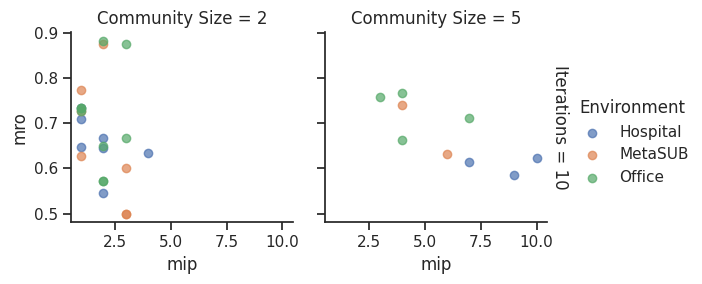

In [87]:
# plotting

sns.set(style="ticks")

# FacetGrid with subplots based on 'Community Size' and 'Iterations'
g = sns.FacetGrid(smetana_results, col="Community Size", row="Iterations", hue="Environment", margin_titles=True)
g.map(plt.scatter, "mip", "mro", alpha=0.7)

# Adding a legend
g.add_legend()

# Displaying the plots
plt.show()

In [122]:
# Generating minimal media for the communities
model_files = glob.glob(model_path + '*.xml')
minimal_media = {}

for env in environments:
    media = []
    organisms = nodes_info[env]
    organisms = sorted([org.replace(" ", "_") for org in organisms])
    models = [item for item in model_files if any(organism in item for organism in organisms)]
    for model in models:
        model_obj = cobra.io.read_sbml_model(model)
        media += list(minimal_medium(model_obj, 0.1, minimize_components=True).keys())

    media = sorted(list(set([element[3:] for element in media])))
    minimal_media[env] = media

minimal_media

Adding exchange reaction EX_13ppd_e with default bounds for boundary metabolite: 13ppd_e.
Adding exchange reaction EX_14glucan_e with default bounds for boundary metabolite: 14glucan_e.
Adding exchange reaction EX_26dap__M_e with default bounds for boundary metabolite: 26dap__M_e.
Adding exchange reaction EX_2mpa_e with default bounds for boundary metabolite: 2mpa_e.
Adding exchange reaction EX_3amp_e with default bounds for boundary metabolite: 3amp_e.
Adding exchange reaction EX_3cmp_e with default bounds for boundary metabolite: 3cmp_e.
Adding exchange reaction EX_3gmp_e with default bounds for boundary metabolite: 3gmp_e.
Adding exchange reaction EX_3mba_e with default bounds for boundary metabolite: 3mba_e.
Adding exchange reaction EX_3ump_e with default bounds for boundary metabolite: 3ump_e.
Adding exchange reaction EX_4abut_e with default bounds for boundary metabolite: 4abut_e.
Adding exchange reaction EX_4hpro_LT_e with default bounds for boundary metabolite: 4hpro_LT_e.
Addi

{'Hospital': ['23camp_e',
  '26dap__M_e',
  '2ameph_e',
  '2pglyc_e',
  '3amp_e',
  '3cmp_e',
  '3gmp_e',
  '3mb_e',
  '3ump_e',
  '4abzglu_e',
  '4ahmmp_e',
  '4hphac_e',
  '5mcsn_e',
  'LalaDgluMdapDala_e',
  'LalaDgluMdap_e',
  'Lcyst_e',
  'R_3httdca_e',
  'acac_e',
  'acgam1p_e',
  'acgam_e',
  'acglu_e',
  'acmana_e',
  'acnam_e',
  'ala_B_e',
  'ala_L_glu__L_e',
  'ala_L_thr__L_e',
  'ala__D_e',
  'ala_gln_e',
  'ala_his_e',
  'ala_leu_e',
  'alaleu_e',
  'amp_e',
  'arbt_e',
  'arg__L_e',
  'asn__L_e',
  'but_e',
  'butso3_e',
  'bz_e',
  'bzalc_e',
  'ca2_e',
  'carn_e',
  'cell6_e',
  'cgly_e',
  'ch4s_e',
  'chol_e',
  'chols_e',
  'chor_e',
  'cit_e',
  'citr__L_e',
  'cl_e',
  'cmp_e',
  'coa_e',
  'cobalt2_e',
  'csn_e',
  'cu2_e',
  'cu_e',
  'cys__L_e',
  'dag181d9_e',
  'ddca_e',
  'dmso2_e',
  'dtmp_e',
  'dxyl_e',
  'f6p_e',
  'fcmcbtt_e',
  'fe2_e',
  'fe3_e',
  'fe3dcit_e',
  'fe3dhbzs3_e',
  'fe3pyovd_kt_e',
  'feenter_e',
  'fol_e',
  'fru_e',
  'g3pc_e',
  'g3pe